# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import pandas as pd
import scipy

In [2]:
PATH_TO_DATA = "./data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar (and different) words: self.score  -  np.argsort 
        distances = np.array([self.score(w,w_other) for w_other in list(self.word2vec.keys())])
        similar_indices = np.argsort(distances)[-(K+1):][::-1]
        similar_words = np.take(list(self.word2vec.keys()), similar_indices)
        return similar_words[1:K+1]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        w1_vec = self.word2vec[w1]
        w2_vec = self.word2vec[w2]
        return np.dot(w1_vec,w2_vec)/(np.linalg.norm(w1_vec,2)*np.linalg.norm(w2_vec,2))

In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats' 'kitty' 'kitten' 'feline' 'kitties']
['dogs' 'puppy' 'Dog' 'doggie' 'canine']
['dog' 'pooches' 'Dogs' 'doggies' 'canines']
['france' 'Paris' 'london' 'berlin' 'tokyo']
['austria' 'europe' 'german' 'berlin' 'poland']


In [5]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        words = list(self.w2v.word2vec.keys())
        if idf is False:
            sentemb = [np.mean([self.w2v.word2vec[w] if w in words else np.zeros(shape=(1,300)) for w in sent.split()], 
                               axis=0) for sent in sentences]
        else:
            sentemb = [np.sum([np.dot(self.w2v.word2vec[w],idf.get(w,1)) if w in words else np.zeros(shape=(1,300)) 
                                            for w in sent.split()], axis = 0)/np.sum(np.array([idf[w] if w in words else 1 for w in sent.split()]))
                       for sent in sentences]
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf)
        keys = keys/np.linalg.norm(keys, 2, 1)[:, None]  # normalize embeddings
        query = query/np.linalg.norm(query, 2)
        scores = np.dot(query, keys.T)  # dot-product of normalized vector = cosine similarity
        idxs = scores[0].argsort()[-K:][::-1]
        return np.take(sentences, idxs)
             
    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        s1_vec = self.encode([s1], idf)
        s2_vec = self.encode([s2], idf)
        return np.dot(s1_vec,s2_vec.T)/(np.linalg.norm(s1_vec,2)*np.linalg.norm(s2_vec,2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in sent.split():
                idf[w] = idf.get(w, 0) + 1
        for word in list(idf.keys()):
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf  

In [10]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=55000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open('data/sentences.txt') as f:
    for i, line in enumerate(f):
        sent = line.rstrip()
        sentences.append(sent)

# You will be evaluated on the output of the following:
most_similar_mean = s2v.most_similar(sentences[10], sentences)# BoV-mean
print('Top 5 NNs of are : \n')
for i, sent in enumerate(most_similar_mean):
    print(str(i+1)+') ', sent)   
print('score BoV-mean : ', s2v.score(sentences[7],sentences[13]))
print('\n')
idf = s2v.build_idf(sentences)  
most_similar_idf = s2v.most_similar(sentences[10], sentences, idf)# BoV-idf
print('Top 5 NNs of are : \n')
for i, sent in enumerate(most_similar_idf):
    print(str(i+1)+') ', sent)   
print('score BoV-idf: ', s2v.score(sentences[7],sentences[13], idf))

Loaded 55000 pretrained word vectors
Top 5 NNs of are : 

1)  1 smiling african american boy .
2)  an african american man smiling .
3)  a little african american boy and girl looking up .
4)  an african american in sunglasses and a white tee-shirt smiles .
5)  an afican american woman standing behind two small african american children .
score BoV-mean :  [[0.57262589]]


Top 5 NNs of are : 

1)  1 smiling african american boy .
2)  an african american man smiling .
3)  an african american man is sitting .
4)  a little african american boy and girl looking up .
5)  an afican american woman standing behind two small african american children .
score BoV-idf:  [[0.4750928]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [11]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

en2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)
fr2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [12]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# common vocab
en_words = list(en2v.word2vec.keys())
fr_words = list(fr2v.word2vec.keys())
inter_vocab = list(set(en_words) & set(fr_words))

# target and sources matrix X and Y
X = np.array([fr2v.word2vec[word] for word in inter_vocab])
Y = np.array([en2v.word2vec[word] for word in inter_vocab])

In [13]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector
from scipy import linalg

# computing the SVD of XY^T is faster than the one of YX^T
V, Sigma, U_t = linalg.svd(np.dot(Y.T,X))
W_opt = np.dot(V,U_t)

In [14]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above
en_words = ['dog','cat','computer','desk','family','friend','car']
fr_words = ['lunette', 'écran','livre','nuage','immeuble','argent','piscine']
fr2en_vec = np.array([np.dot(W_opt,fr2v.word2vec[word]) for word in fr_words])
en2fr_vec = np.array([np.dot(W_opt.T,en2v.word2vec[word]) for word in en_words])

K=5
ind=0
# most similar in english
print('From French to English')
for vec in fr2en_vec:
    distances = np.array([np.dot(vec,en2v.word2vec[w])/(np.linalg.norm(vec,2)*np.linalg.norm(en2v.word2vec[w],2)) 
                          for w in list(en2v.word2vec.keys())])
    similar_indices = np.argsort(distances)[-K:][::-1]
    similar_words = np.take(list(en2v.word2vec.keys()), similar_indices)
    print(fr_words[ind],':',similar_words[0:K])
    ind=ind+1

ind=0
# most similar in french
print('\n'+'From English to French')
for vec in en2fr_vec:
    distances = np.array([np.dot(vec,fr2v.word2vec[w])/(np.linalg.norm(vec,2)*np.linalg.norm(fr2v.word2vec[w],2)) 
                          for w in list(fr2v.word2vec.keys())])
    similar_indices = np.argsort(distances)[-K:][::-1]
    similar_words = np.take(list(fr2v.word2vec.keys()), similar_indices)
    print(en_words[ind],':',similar_words[0:K])
    ind=ind+1

From French to English
lunette : ['telescopic' 'telescopes' 'binoculars' 'telescope' 'rangefinder']
écran : ['screen' 'onscreen' 'screens' 'projector' 'pixels']
livre : ['book' 'preface' 'foreword' 'afterword' 'livre']
nuage : ['clouds' 'cloud' 'plumes' 'ionized' 'thunderstorm']
immeuble : ['apartment' 'building' 'townhouse' 'townhouses' 'apartments']
argent : ['gold' 'silver' 'bullion' 'bronze' 'medallist']
piscine : ['swimming' 'pool' 'toilets' 'foyer' 'playgrounds']

From English to French
dog : ['dog' 'chien' 'hound' 'chiens' 'chienne']
cat : ['cat' 'chat' 'dog' 'chats' 'chien']
computer : ['computer' 'informatique' 'ordinateurs' 'ordinateur' 'computing']
desk : ['desk' 'room' 'please' 'svp' 'secretary']
family : ['famille' 'family' 'familles' 'familial' 'families']
friend : ['ami' 'amie' 'friend' 'camarade' 'admirateur']
car : ['voiture' 'voitures' 'automobile' 'porsche' 'automobiles']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [15]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# Train and dev data
def xtr_data_labeled(path):
    data_set= open(PATH_TO_DATA + "SST/" + path, "r",encoding="utf-8").read()
    data_set = data_set.split('\n')
    data_set = data_set[0:len(data_set)-1]
    labels = [int(elem[0]) for elem in data_set]
    data_set_final = [elem[2:-2] for elem in data_set]
    return np.array(data_set_final), np.array(labels)
    
trainx, trainy  = xtr_data_labeled("stsa.fine.train")
devx, devy = xtr_data_labeled("stsa.fine.dev")

# Test data 
test_set= open(PATH_TO_DATA + "SST/" + "stsa.fine.test.X", "r").read()
testx = test_set.split('\n')
testx = testx[0:len(testx)-1]

In [16]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)
sentemb = s2v.encode(trainx)
sentemb_dev = s2v.encode(devx)

Loaded 200000 pretrained word vectors


In [17]:
idf = s2v.build_idf(trainx)
idf_dev = s2v.build_idf(devx)
sentemb_idf = s2v.encode(trainx,idf)
sentemb_idf_dev = s2v.encode(devx,idf_dev)

In [19]:
# Packages loading
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, cross_validation
from sklearn.metrics import accuracy_score

In [20]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# Logistic regression on BoV mean

# Model
logreg = LogisticRegression(C = 0.25, solver='lbfgs', multi_class='multinomial')

X = sentemb
y = trainy
logreg.fit(X, y)

# Accuracy on dev set
pred_devy = logreg.predict(sentemb_dev)
print('Dev acc : ', accuracy_score(devy, pred_devy))

# Accuracy on train set with CV
pred_trainy = cross_validation.cross_val_predict(logreg, sentemb, trainy, cv=10)
print('Train acc : ', metrics.accuracy_score(trainy, pred_trainy))

Dev acc :  0.4296094459582198
Train acc :  0.4387874531835206


In [21]:
# Grid Search
param_grid = {'C': [x/100 for x in range(1,100)]}
logreg=LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg_opt = GridSearchCV(logreg, param_grid)
X_dev = sentemb_dev
y_dev = devy
logreg_opt.fit(X_dev, y_dev)

print("tuned hpyerparameters :(best parameters) ",logreg_opt.best_params_)
print("accuracy :",logreg_opt.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.25}
accuracy : 0.3905540417801998


In [22]:
# Logistic regression on BoV mean-idf
logreg2 = LogisticRegression(C=0.25, solver='lbfgs', multi_class='multinomial')
X2 = sentemb_idf
y = trainy
logreg2.fit(X2, y)

# Accuracy on dev set
pred_devy_idf = logreg2.predict(sentemb_idf_dev)
print('Dev acc : ', accuracy_score(devy, pred_devy_idf))

# Accuracy on train set with CV
pred_trainy_idf = cross_validation.cross_val_predict(logreg2, sentemb_idf, trainy, cv=10)
print('Train acc : ', metrics.accuracy_score(trainy, pred_trainy_idf))

Dev acc :  0.4287011807447775
Train acc :  0.43340355805243447


In [23]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

sentemb_test = s2v.encode(testx)
pred_testy = logreg_opt.predict(sentemb_test)

In [26]:
np.savetxt('./logreg_bov_y_test_sst.txt', [str(x) for x in pred_testy], fmt="%s", delimiter=',') 

In [ ]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [36]:
import keras
from keras.preprocessing.text import text_to_word_sequence
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot

In [30]:
# 1 - Load train/dev/test sets of SST

# Train and dev data
train_set= open(PATH_TO_DATA + "SST/" + "stsa.fine.train", "r").read()
dev_set= open(PATH_TO_DATA + "SST/" + "stsa.fine.dev", "r").read()

# Test data 
test_set= open(PATH_TO_DATA + "SST/" + "stsa.fine.test.X", "r").read()

In [31]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

words_train = set(text_to_word_sequence(train_set))
vocab_size_train = len(words_train)

tokenizer = Tokenizer(num_words=vocab_size_train)
tokenizer.fit_on_texts(trainx)

train_data = tokenizer.texts_to_sequences(trainx)
dev_data = tokenizer.texts_to_sequences(devx)                                       

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [32]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

maxlen = max([len(elem) for elem in train_data])

x_train = keras.preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen, dtype='int32', 
                                                               padding='pre', truncating='pre', value=0.0)
x_val = keras.preprocessing.sequence.pad_sequences(dev_data, maxlen=maxlen, dtype='int32', 
                                                               padding='pre', truncating='pre', value=0.0)

## 4.2 - Design and train your model

In [42]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = x_train.shape[1]  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = vocab_size_train  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))

In [43]:
# 5 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 49)          751562    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                29184     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 781,071
Trainable params: 781,071
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
bs = 64
n_epochs = 4
y_train = to_categorical(trainy)
y_val = to_categorical(devy)

history = model.fit(x_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(x_val, y_val))

Train on 8544 samples, validate on 1101 samples
Epoch 1/4
8544/8544 [==============================] - 24s 3ms/step - loss: 1.5741 - acc: 0.2769 - val_loss: 1.5655 - val_acc: 0.2652
Epoch 2/4
8544/8544 [==============================] - 24s 3ms/step - loss: 1.4546 - acc: 0.3535 - val_loss: 1.3779 - val_acc: 0.3787
Epoch 3/4
8544/8544 [==============================] - 24s 3ms/step - loss: 1.1669 - acc: 0.4569 - val_loss: 1.3825 - val_acc: 0.3842
Epoch 4/4
8544/8544 [==============================] - 24s 3ms/step - loss: 0.9200 - acc: 0.5614 - val_loss: 1.5144 - val_acc: 0.3860


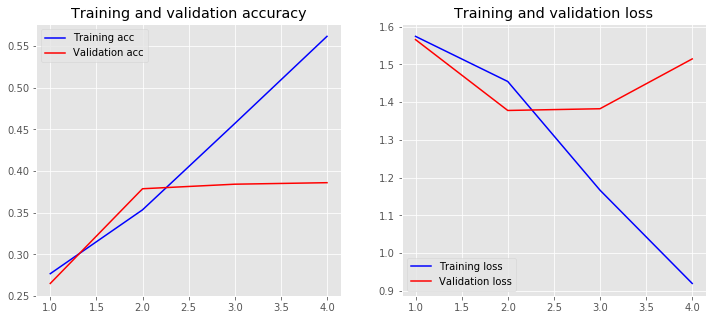

In [48]:
# plot of the results

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
plot_history(history)

In [54]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# prep-processing of test-data
test_data = tokenizer.texts_to_sequences(testx)
x_test = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen, dtype='int32', 
                                                               padding='pre', truncating='pre', value=0.0)

pred_testy_lstm_probs = model.predict(x_test)
pred_testy_lstm = [list(probs).index(max(probs)) for probs in pred_testy_lstm_probs]

In [56]:
np.savetxt('./logreg_lstm_y_test_sst.txt', [str(x) for x in pred_testy_lstm], fmt="%s", delimiter=',') 

## 4.3 -- innovate !

In [ ]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.
# TYPE CODE HERE